In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import optimize, interpolate, stats, special, integrate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.optimize import basinhopping
import warnings
import pickle

# データの整理

In [141]:
# /data/df.pickleの読み込み
df = pd.read_pickle('../data/df.pickle')

df = df.dropna()

# データの分割
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')].dropna()
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')].dropna()
df_p3 = df[(df['started_at'] >= '2020-12-01') & (df['started_at'] < '2021-03-01')].dropna()
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')].dropna()
df_p4_1 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2022-01-01')].dropna()
df_p4_2 = df[(df['started_at'] >= '2022-01-01') & (df['started_at'] < '2023-10-01')].dropna()
df_left = pd.concat([df_p1, df_p2, df_p3, df_p4_1], axis=0)
df_right = pd.concat([df_p4_2], axis=0)



In [142]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]

    return active_node_list, edge_list, timestamp

In [143]:
node_left, edge_left, timestamp_left = return_nm(df_left)

In [144]:
# node_leftとedge_leftを組みにしてdf_leftを作成
left = pd.DataFrame({'node': node_left, 'edge': edge_left})
# df_leftのnodeを昇順にして並び替え
left = left.sort_values(by='node')
# インデックスを振り直す
left = left.reset_index(drop=True)
left.head()

,node,edge
0,106,190
1,136,221
2,173,312
3,215,368
4,217,494


In [145]:
left

,node,edge
0,106,190
1,136,221
2,173,312
3,215,368
4,217,494
...,...,...
603,609,32694
604,609,20769
605,610,27349
606,613,21726


In [146]:
# 正規化する
left["node_norm"] = left["node"] - left["node"].min() + 2
left["edge_norm"] = left["edge"] - left["edge"].min() + 1

# 一番最初の行を削除
left = left.drop(0)

# インデックスを振り直す
left = left.reset_index(drop=True)


In [147]:
M = left["edge"] #left["edge_norm"]
N = left["node"] #left["node_norm"]

# モデル1、2
activity parameterが均一分布に従うとしたときのモデル。
* Model1
    * $N_p$を固定して$\kappa$を推定するモデル。
* Model2
    * $\kappa$を固定して$N_p$を推定するモデル。    


In [148]:
def Model1(M,kappa):
    def Np(kappa):
        return (1+np.sqrt(1+32*M/kappa))/2
    N = Np(kappa)*(1-2/kappa/Np(kappa)*(1 - (1-kappa/2)**Np(kappa)))
    return N


def Model2(M,Np):
    def kappa(Np):
        return 8*M/Np/(Np-1)
    N = Np*(1 - 2/kappa(Np)/Np*(1 - (1-kappa(Np)/2)**Np))
    return N



In [149]:
kappa_hat, _ = np.count = optimize.curve_fit(Model1, M, N)
optimize.curve_fit(Model1, M, N)

c:\Users\Yoshitaka\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Yoshitaka\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Yoshitaka\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Yoshitaka\AppData\Local\Temp\ipykernel_19332\1276519163.py:15: RuntimeWarning: invalid value encountered in scalar power
  N = Np*(1 - 2/kappa/Np*(1 - (1-kappa/2)**Np))


(array([105.67944232,   1.9999994 ]),
 array([[ 3.15922899e+19, -6.31845616e+19],
        [-6.31845616e+19,  1.26369087e+20]]))

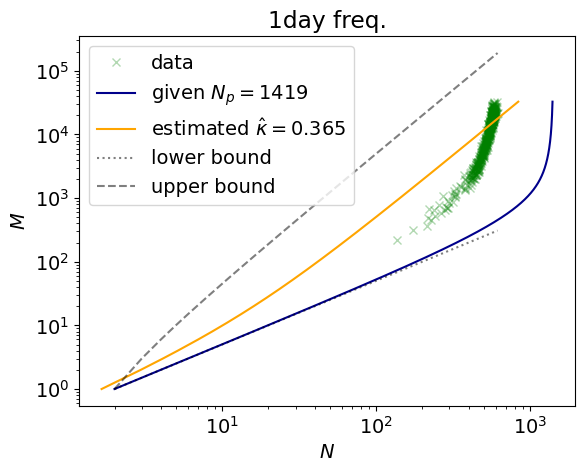

In [151]:
plt.rcParams["font.size"]=14
Np = 1419
x = np.arange(2,np.max(N))
y = np.arange(1,np.max(M))

plt.plot(N, M, "x", c="green", alpha=0.3, label = "data")
plt.plot(Model2(y,Np), y, "-", c="darkblue", label = r"given $N_p=1419$")
plt.plot(Model1(y,kappa_hat), y, "-", c="orange", label = r"estimated $\hat{\kappa} = 0.365$")
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.title("1day freq.")
plt.legend()

# モデル3
activity parameterがベータ分布に従うときのモデル
* Model3
    * $N_p=1419$で固定
        * ソース: https://data.cityofchicago.org/Transportation/Divvy-Bicycle-Stations-Historical/eq45-8inv
    * $\alpha, \beta$をあてずっぽうに設定して、とりあえず図示して確認。

In [200]:
Np = 1419
alpha = 0.1
beta = 0.5


def Model3(M):

    def obj(a,i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)

    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]

    N = Np*(1 - vals)
    return N

def kappa(M, Np):
    return ((alpha+beta)/alpha)**2*2*M/Np/(Np-1)


C:\Users\Yoshitaka\AppData\Local\Temp\ipykernel_19332\1735498209.py:14: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  vals[i] = integrate.quad(obj,0,1, args=(i))[0]


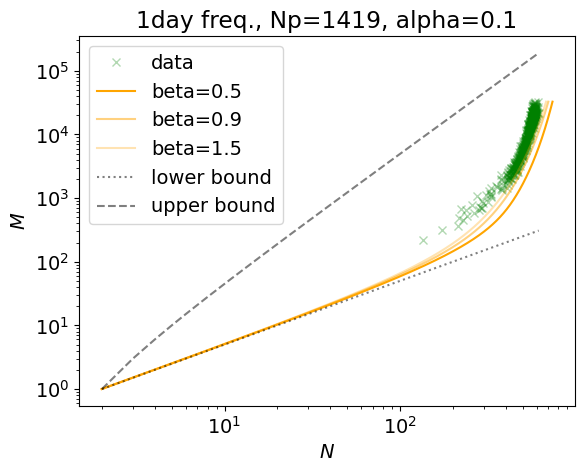

In [208]:
plt.rcParams["font.size"]=14
Np = 1419
x = np.arange(2,np.max(N))
y = np.arange(1,np.max(M))

# data
plt.plot(N, M, "x", c="green", alpha=0.3, label = "data")

# model
alpha = 0.1
beta = 0.5
plt.plot(Model3(y), y, "-", c="orange", label=f"beta={str(beta)}")

alpha = 0.1
beta = 0.9
plt.plot(Model3(y), y, "-", c="orange", label=f"beta={str(beta)}",alpha = 0.5)

alpha = 0.1
beta = 1.5
plt.plot(Model3(y), y, "-", c="orange", label=f"beta={str(beta)}",alpha = 0.3)

# bound and others
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.title("1day freq., Np=1419, alpha=0.1")
plt.legend()

C:\Users\Yoshitaka\AppData\Local\Temp\ipykernel_19332\1735498209.py:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  vals[i] = integrate.quad(obj,0,1, args=(i))[0]
C:\Users\Yoshitaka\AppData\Local\Temp\ipykernel_19332\1735498209.py:14: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  vals[i] = integrate.quad(obj,0,1, args=(i))[0]


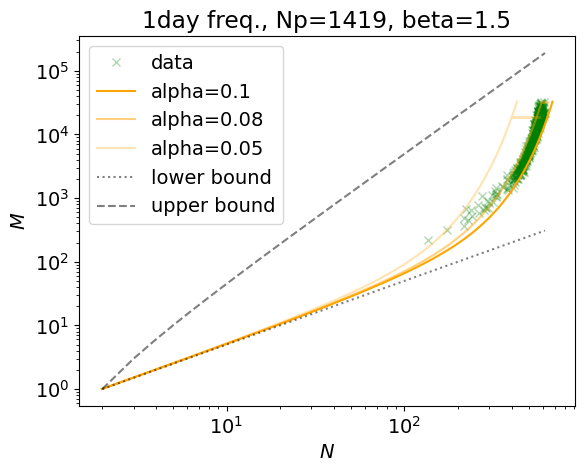

In [209]:
plt.rcParams["font.size"]=14
Np = 1419
x = np.arange(2,np.max(N))
y = np.arange(1,np.max(M))

# data
plt.plot(N, M, "x", c="green", alpha=0.3, label = "data")

# model
alpha = 0.1
beta = 1.5
plt.plot(Model3(y), y, "-", c="orange", label=f"alpha={str(alpha)}")
alpha = 0.08
beta = 1.5
plt.plot(Model3(y), y, "-", c="orange", label=f"alpha={str(alpha)}", alpha = 0.5)

alpha = 0.05
beta = 1.5
plt.plot(Model3(y), y, "-", c="orange", label=f"alpha={str(alpha)}", alpha = 0.3)

# bound and others
plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.title("1day freq., Np=1419, beta=1.5")
plt.legend()